# 「台指期連續月」商品過去6年(2014到2019)日線圖
##### 考慮到商品換月轉倉的複雜性，故此篇只研究當沖交易的回測績效
![chart](https://i.imgur.com/OeIomYX.jpg)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# 隨機森林所需套件，算特徵值的顯著性
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 能讓圖片顯示中文與數字的負號
import matplotlib.font_manager as fm
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf" 
cht = fm.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf') 
plt.rcParams['axes.unicode_minus']=False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/MaxChenCMC/TX_intraday_long_only_strategy_backtest/master/tx00.csv',index_col = 0)['2014':'2020-01-02']

# 多方指標
df['red3'] = np.where( (df['Close'] > df['Open']).rolling(3).sum() >= 3, 1, 0) # 連3天紅k
df['hhhl'] = np.where( ((df['High'] > df['High'].shift()) & (df['Low'] > df['Low'].shift())).rolling(3).sum() >= 3, 1, 0) # 連3天高過高且低不破低
df['engulfing'] = np.where( (df['High'].shift() < df['High']) & (df['Low'].shift() > df['Low']) , 1, 0) # 今高今低都超過昨天範圍的吞噬k棒
df['backwardation'] = np.where( df['Spread'] > 90 , 1, 0) # 逆價差要幾點
df['lower_shadow'] = 0  # (不論紅或黑k)下影線超過50點且下影線要超過實體k的一半
for i in range(len(df)):
    df['lower_shadow'][i] = np.where( ((min(df['Close'][i],df['Open'][i]) - df['Low'][i]) > abs(df['Close'][i]-df['Open'][i])/2) & ((min(df['Close'][i],df['Open'][i]) - df['Low'][i]) > 50), 1, 0) 

# 空方指標
df['black3'] = np.where( (df['Close'] < df['Open']).rolling(3).sum() >= 3, 1, 0) # 連3天黑k
df['lllh'] = np.where( ((df['High'] < df['High'].shift()) & (df['Low'] < df['Low'].shift())).rolling(3).sum() >= 3, 1, 0) # 連3天高不過高且低破低
df['harami'] = np.where( (df['High'].shift() > df['High']) & (df['Low'].shift() < df['Low']) , 1, 0) # 今高今低都縮在昨天範圍的母子線
df['down3'] = np.where( (df['Close'].diff() < 0).rolling(3).sum() >= 3, 1, 0) # 連跌3天
df['evening_star'] = np.where( (abs(df['Open'] - df['Close']) <= 10) & (df['High'] - df['Low'] >= 50) , 1, 0) # 全距超過50點且實體k不大於10點的十字星  未再細分是真十字？上影線？下影線？
df['upper_shadow'] = 0  # (不論紅或黑k)上影線超過50點且上影線要超過實體k的一半
for i in range(len(df)):
    df['upper_shadow'][i] = np.where( ((df['High'][i] - max(df['Close'][i],df['Open'][i])) > abs(df['Close'][i]-df['Open'][i])/2) & ((df['High'][i] - max(df['Close'][i],df['Open'][i])) > 30), 1, 0) 

# 希望能預測「隔天是紅k」，欄名取為label 
df['label'] = np.where( df['Close'].shift(-1) > df['Open'].shift(-1) , 1, 0) 
df = df[:-1] # 去掉當年第一個交易日，它是為了算去年最後一天的label
display(df.tail())

# 近一個月(取22個交易日)為測試集，其它為訓練集
train_data, test_data = df[:-22], df[-22:]
train_x = train_data.iloc[:,6:-1].values
train_y = train_data['label'].values
test_x = test_data.iloc[:,6:-1].values
test_y = test_data['label'].values

clf = RandomForestClassifier( criterion='entropy', max_depth= 5, n_estimators= 64)
model = clf.fit(train_x,train_y)
feature_imp = pd.Series(clf.feature_importances_, index = train_data.columns[6:-1]).sort_values(ascending = False)
print(feature_imp)
train_acc, test_acc = accuracy_score(train_y, model.predict(train_x)), accuracy_score(test_y, model.predict(test_x))
print(f'訓練集準度{train_acc}\n測試集準度{test_acc}')

,Open,High,Low,Close,Volume,Spread,red3,hhhl,engulfing,backwardation,lower_shadow,black3,lllh,harami,down3,evening_star,upper_shadow,label
date,,,,,,,,,,,,,,,,,,
2019-12-25,11989.0,12027.0,11976.0,12019.0,41574.0,-10.870117,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-26,12029.0,12042.0,11986.0,12007.0,52146.0,-5.990234,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-27,12038.0,12112.0,12037.0,12097.0,74436.0,-5.410156,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-30,12091.0,12125.0,12065.0,12069.0,66052.0,-15.629883,0,1,0,0,0,0,0,0,0,0,1,0
2019-12-31,12029.0,12049.0,11994.0,11994.0,74341.0,3.139648,0,0,0,0,0,0,0,0,0,0,0,1


upper_shadow     0.172183
evening_star     0.123508
black3           0.115611
lower_shadow     0.102398
engulfing        0.087367
backwardation    0.085358
down3            0.083789
red3             0.076459
hhhl             0.071294
lllh             0.043032
harami           0.038999
dtype: float64
訓練集準度0.5704419889502762
測試集準度0.45454545454545453


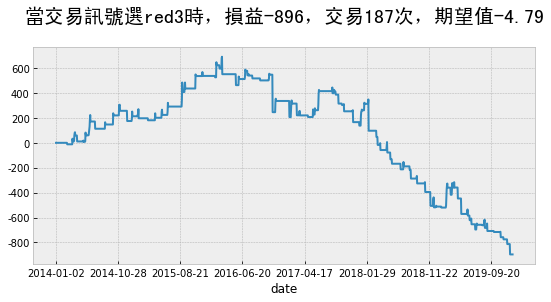

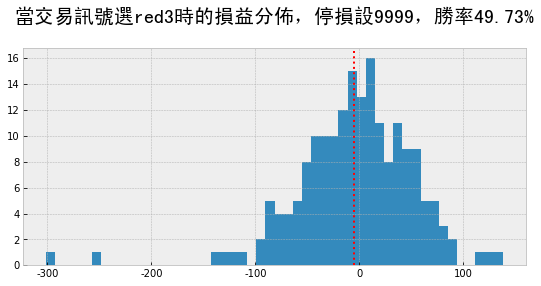

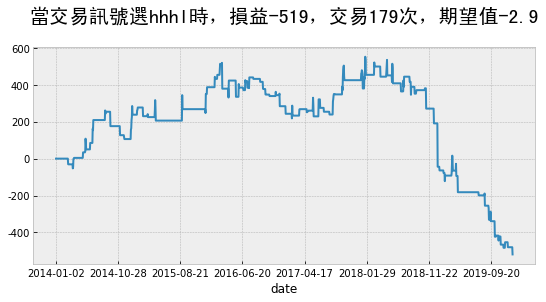

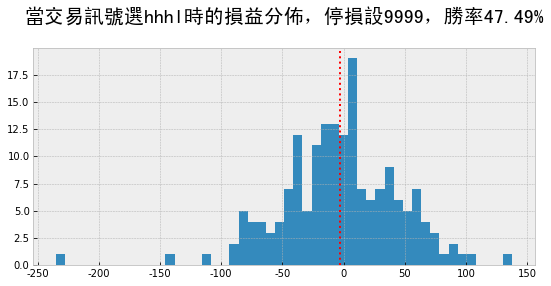

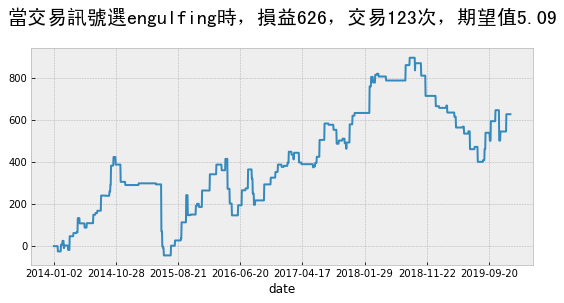

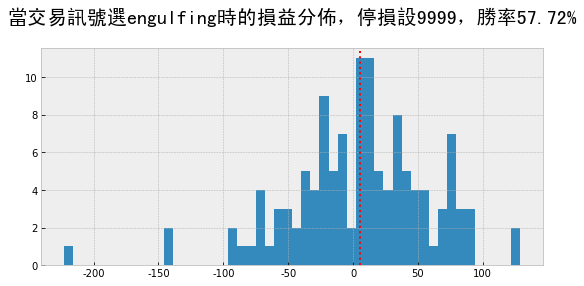

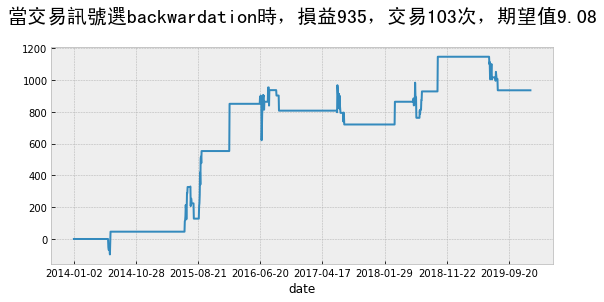

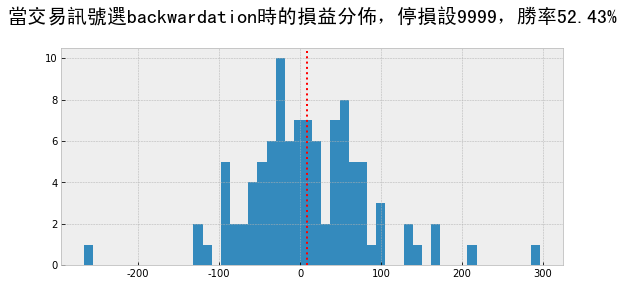

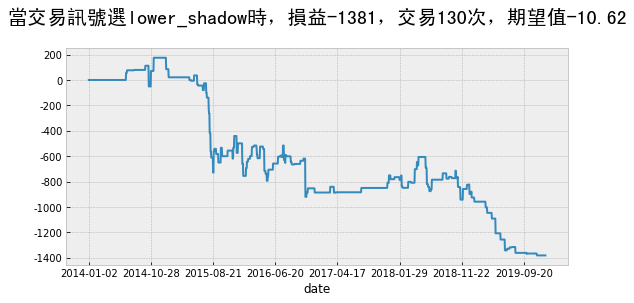

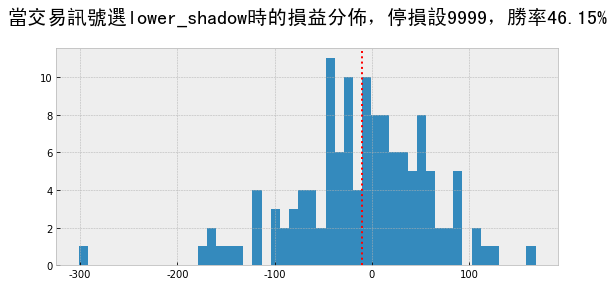

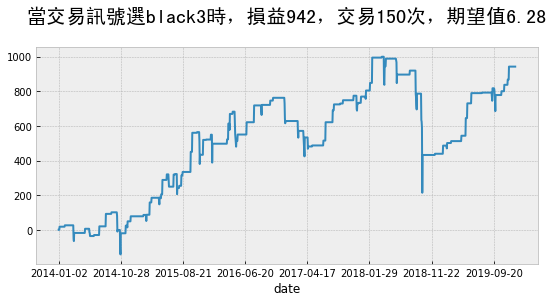

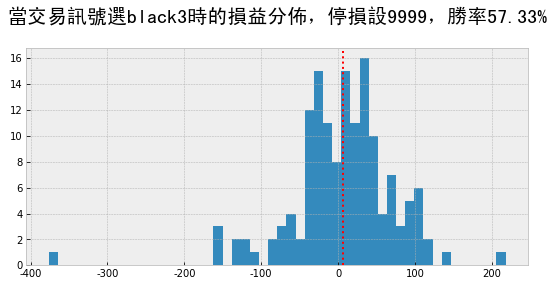

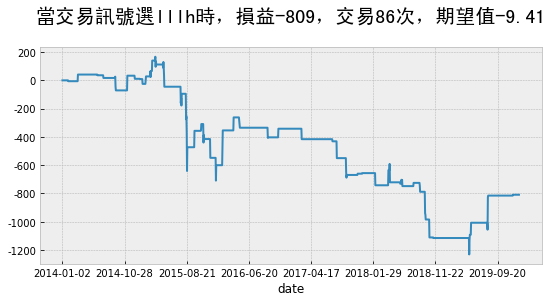

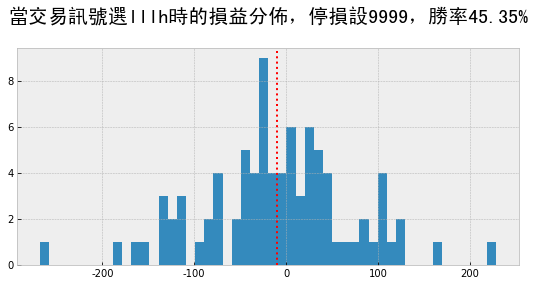

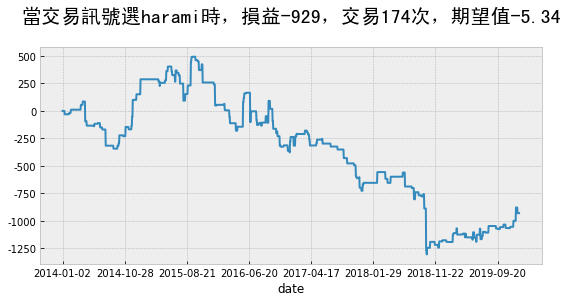

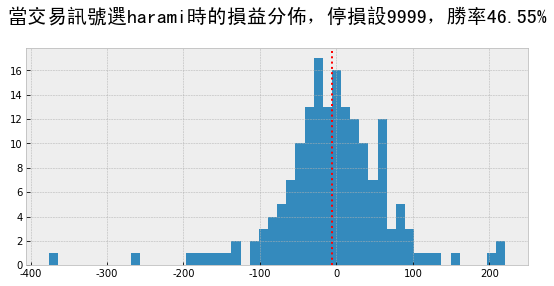

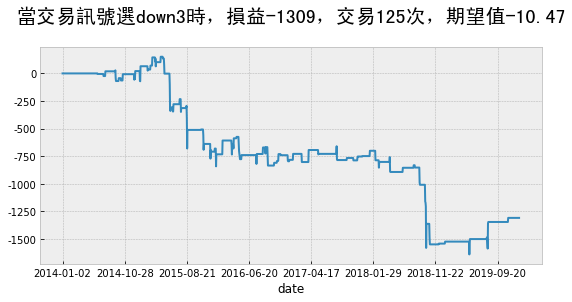

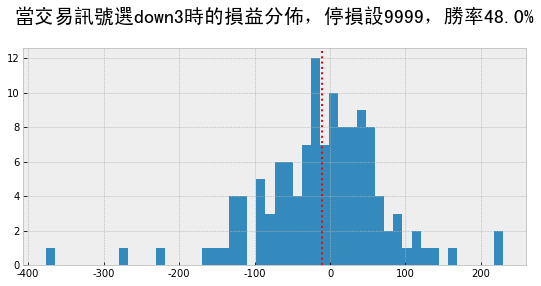

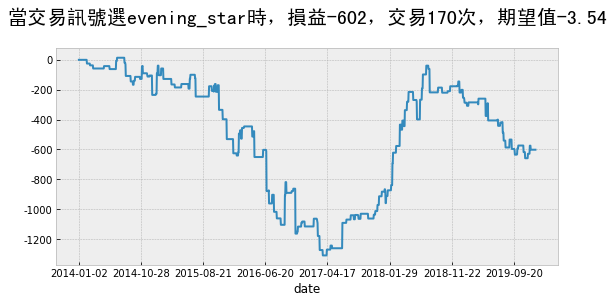

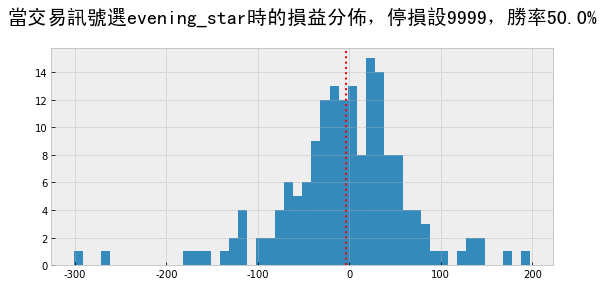

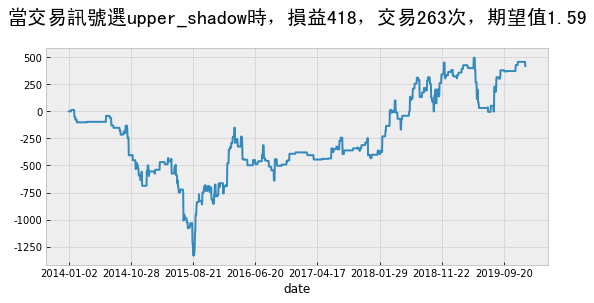

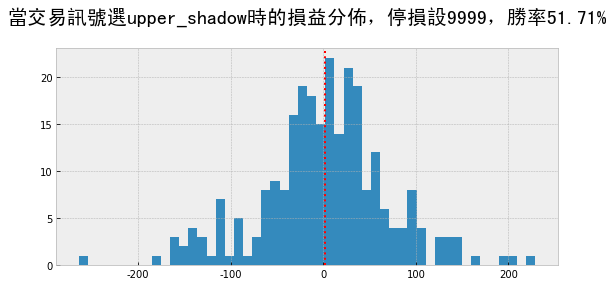

In [3]:
def backtest(i, stp = 9999):    
    '''
    Args:
        arg1: 帶入features名稱，可指定也可迴圈
        arg2: 停損點位，預設9999等同不停損

    Returns:
        畫圖已寫在最後幾行，返回空值即可
    
    Improvement:
        排版用subplots
    '''
    df['signal'] = df[i].shift()
    df['PnL'] = 0

    for i in range(len(df)):
        if df['signal'][i] == 1:
            if df['Low'][i] < df['Open'][i] - stp:
                df['PnL'][i] = -stp -4
            else:
                df['PnL'][i] = df['Close'][i] - df['Open'][i] -4
        else:continue

    # title直接用f-string顯示交易明細
    pnl = df['PnL'].sum()
    lots = len(df[df['signal'] == 1])
    
    
    plt.figure(figsize=(9,4)) # 為了別讓日期糊在一起，只好規定尺寸
    plt.title(f'當交易訊號選{feature}時，損益{pnl}，交易{lots}次，期望值{(pnl/lots).round(2)}\n',fontproperties= cht, fontsize=20)
    df['PnL'].cumsum().plot() 

    plt.figure(figsize=(9,4))
    win_rate = round((len(df[df['PnL'] > 0]) / lots)*100,2)
    plt.title(f'當交易訊號選{feature}時的損益分佈，停損設{stp}，勝率{win_rate}%\n',fontproperties= cht, fontsize=20)
    plt.hist(df['PnL'][df['PnL']!=0] , bins= 50)
    plt.axvline(df['PnL'][df['PnL']!=0].mean(), c='r', ls = ':') # 紅色虛線為損益的平均值
    return 

for feature in df.columns[6:-1]:
    '''
    各個features逐一畫出損益曲線圖
    '''
    backtest(feature)

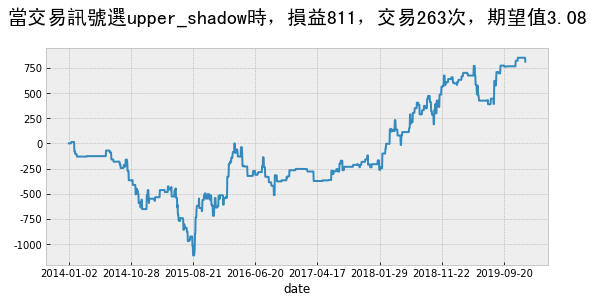

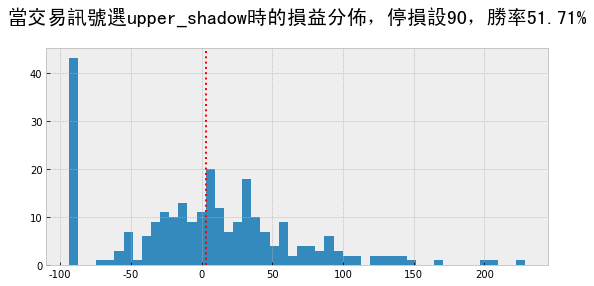

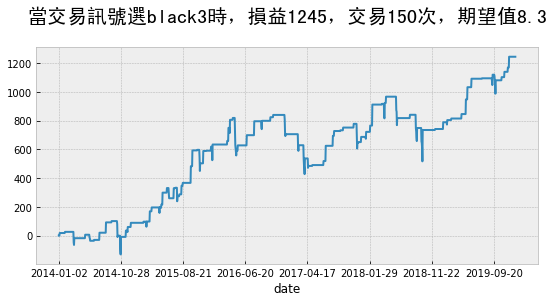

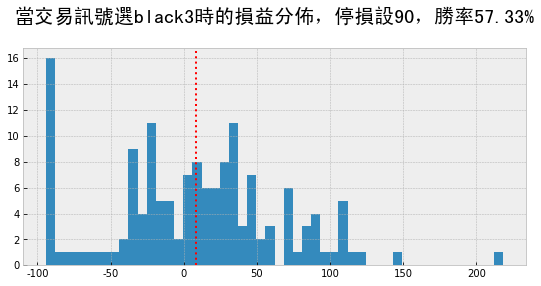

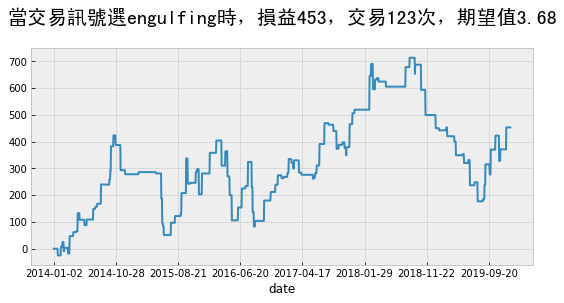

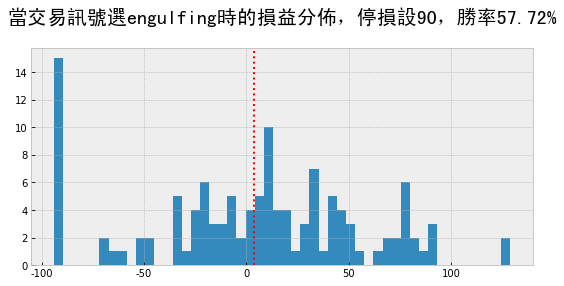

In [4]:
# 把隨機森林特feature_importances_ > 0.1的特徵 & 跟上一個cell逐一算出正期望值的特徵，取聯集的三個特徵，再進一步尋找最適合交易風格的停損範圍
for feature in ['upper_shadow','black3','engulfing']:
    # 以停損90點為例，兩個期望值有提升，一個反而下降
    backtest(feature, stp = 90) 